### This notebook was made for recognising facial expressions of a person.

Traditional convolutional layers are used with "Relu" as the activation function. 

The most optimal model parameters are stored in a model_weights.h5 file, while the model overall is stored in a json file for reproducing the model without repetitive training.

Using TensorFlow backend.


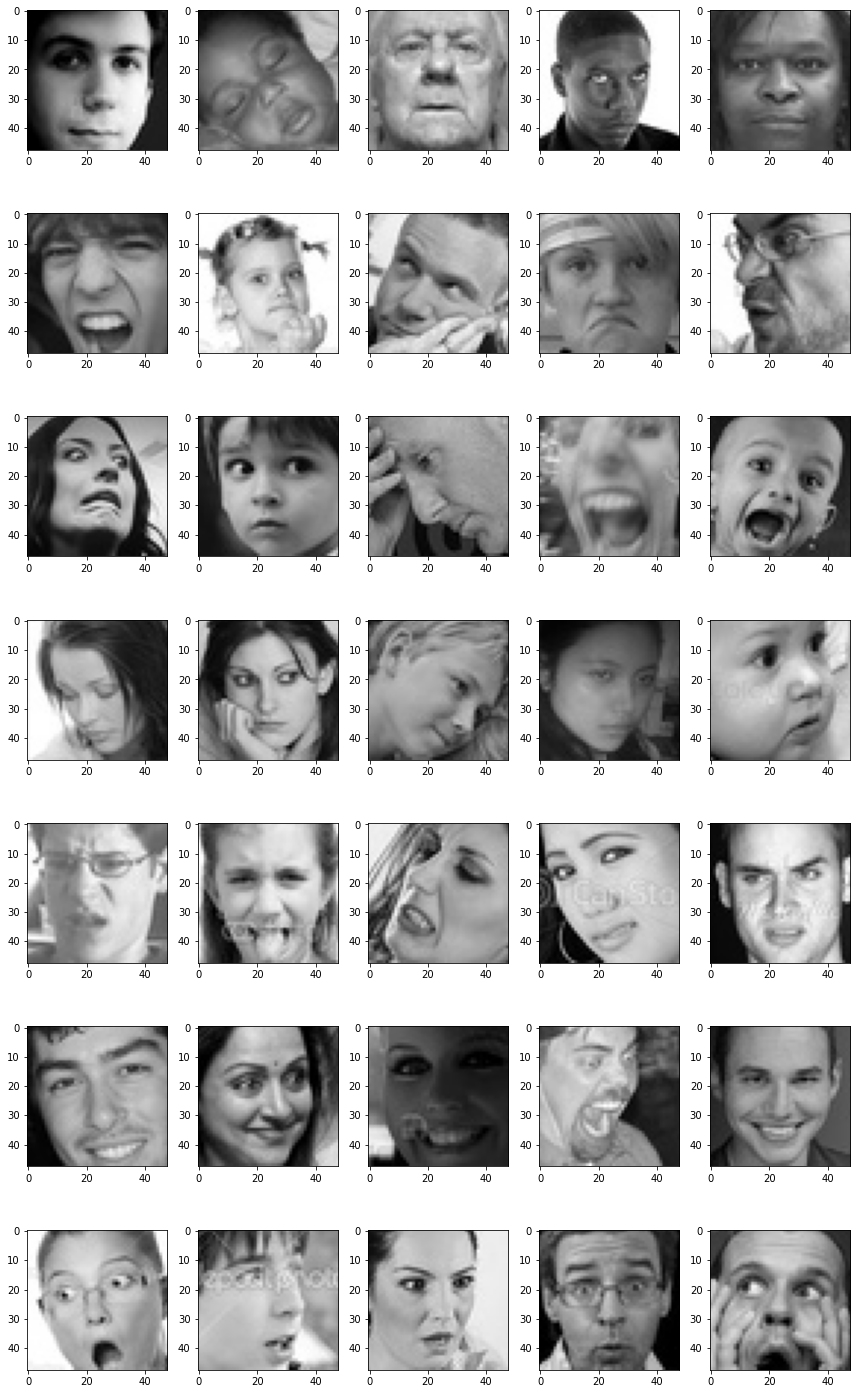

In [1]:
import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img,img_to_array
import matplotlib.pyplot as plt
import os

pic_size = 48

base_path = "/kaggle/input/facial-recognition-dataset/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "Training/Training/"):
    for i in range(1,6):
        cpt += 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path+'Training/Training/'+expression+"/"+os.listdir(base_path+"Training/Training/"+expression)[i],target_size=(pic_size,pic_size))
        plt.imshow(img,cmap="gray")
        pass
    pass

plt.tight_layout()
plt.show()

In [2]:
for expression in os.listdir(base_path+"Training/Training/"):
    print(str(len(os.listdir(base_path+"Training/Training/"+expression)))+" "+expression+" images")
    pass

4965 Neutral images
3995 Angry images
4097 Fear images
4830 Sad images
436 Disgust images
7215 Happy images
3171 Suprise images


In [3]:
datasets = ['../input/facial-recognition-dataset/Training/Training','../input/facial-recognition-dataset/Testing/Testing']

output = []

class_names = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Suprise']

class_name_labels = {class_name:j for j,class_name in enumerate(class_names)}

nb_classes = len(class_names)
class_name_labels

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Suprise': 6}

In [4]:
from tqdm import tqdm
import cv2

def load_dataset():
    
    for dataset in datasets:
        
        print("Loading {}".format(dataset))
        images,labels = [],[]
        
        for folder in os.listdir(dataset):
            label = class_name_labels[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                
                img_path = os.path.join(os.path.join(dataset,folder),file)
                
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img,(48,48))
                
                images.append(img)
                labels.append(label)
                pass
            pass
        
        images = np.array(images,dtype=np.float32)
        labels = np.array(labels,dtype=np.float32)
        
        output.append((images,labels))
        pass
    
    return output
    pass

In [5]:
(train_images,train_labels),(test_images,test_labels) = load_dataset()

  1%|          | 33/4965 [00:00<00:15, 321.97it/s]

Loading ../input/facial-recognition-dataset/Training/Training


  3%|▎         | 42/1233 [00:00<00:02, 416.09it/s]

Loading ../input/facial-recognition-dataset/Testing/Testing


100%|██████████| 831/831 [00:02<00:00, 303.37it/s]


In [6]:
import pandas as pd

n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

_, train_count = np.unique(train_labels,return_counts=True)
_, test_count = np.unique(test_labels,return_counts=True)

df = pd.DataFrame(data = (train_count,test_count))
df = df.T
df['Name'] = class_names
df

,0,1,Name
0,3995,958,Angry
1,436,111,Disgust
2,4097,1024,Fear
3,7215,1774,Happy
4,4965,1233,Neutral
5,4830,1247,Sad
6,3171,831,Suprise


<Figure size 432x288 with 0 Axes>

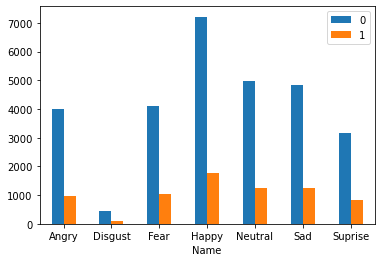

In [7]:
plt.figure()
df.set_index('Name').plot.bar(rot=0)

As it can be seen that there is major class imbalance, there are very few disgust images present in the database.

A way for countering this is by using reducing the training set for the remaining images, especially in `Happy`.

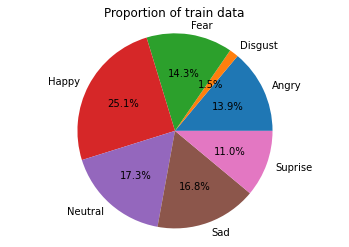

In [8]:
plt.pie(train_count,
       explode=(0,0,0,0,0,0,0),
       labels=class_names,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title("Proportion of train data")
plt.show()

This give a more accurate picture of the class imabalance present in the dataset. The highest is occupied by `Happy` with 25.1% and lowest with `Disgust` at an astonishingly low percantage of 1.5.

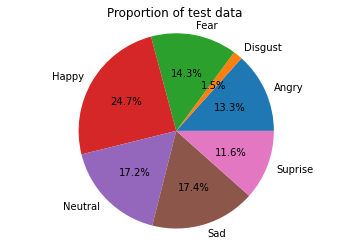

In [9]:
plt.pie(test_count,
       explode=(0,0,0,0,0,0,0),
       labels=class_names,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title("Proportion of test data")
plt.show()

Even in the test dataset, there is a similar class imbalance present. Though there is no overall difference in percentage of images between the train and test datasets.

For a much better model the disgust data can be removed from the dataset and training on the remaining data, or obtain more data for the disgust dataset.

In [10]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 64

datagen_train = ImageDataGenerator(rescale = 1./255)
datagen_test = ImageDataGenerator(rescale = 1./255)

train_generator = datagen_train.flow_from_directory(base_path + "Training/Training",
                                                   target_size = (pic_size,pic_size),
                                                   color_mode="grayscale",
                                                   batch_size=batch_size,
                                                   class_mode = "categorical",
                                                   shuffle=True)
test_generator = datagen_test.flow_from_directory(base_path + "Testing/Testing",
                                                 target_size = (pic_size,pic_size),
                                                 color_mode = "grayscale",
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [11]:
train_generator.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Suprise': 6}

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Sequential,Input,Model

from keras.initializers import *

In [13]:
def identity_block(X,k,filters,stage,block):
    
    conv_name_base = 'res_'+str(stage)+block+'_branch'
    bn_name_base = 'bn_'+str(stage)+block+'_branch'
    
    F1,F2,F3 = filters
    
    X_shortcut = X
    
    # First Component of Main Path
    X = Conv2D(filters=F1,kernel_size=(3,3),strides=(1,1),
               padding='same',name=conv_name_base+'2a',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    # Second Component of Main Path
    X = Conv2D(filters=F2,kernel_size=(k,k),strides=(1,1),
              padding='same',name=conv_name_base+'2b',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    # Third Component of Main Path
    X = Conv2D(filters=F3,kernel_size=(3,3),strides=(1,1),
              padding='same',name=conv_name_base+'2c',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base+'2c')(X)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X
    pass

In [17]:
def convolutional_block(X,k,filters,stage,block,s=2):
    
    conv_base_name = 'res_' + str(stage) + block + '_branch'
    bn_base_name = 'bn_' + str(stage) + block + '_branch'
    
    F1,F2,F3 = filters
    
    X_shortcut = X
    
    ### MAIN PATH ###
    # First component of main path
    X = Conv2D(filters=F1,kernel_size=(3,3),strides=(s,s),
              padding='same',name=conv_base_name+'2a',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation('relu')(X)
    
    # Second Component of main path
    X = Conv2D(filters=F2,kernel_size=(k,k),strides=(1,1),
              padding='same',name=conv_base_name+'2b',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_base_name+'2b')(X)
    X = Activation('relu')(X)
    
    # Third Component of main path
    X = Conv2D(filters=F3,kernel_size=(3,3),strides=(1,1),
              padding='same',name=conv_base_name+'2c',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_base_name+'2c')(X)
    
    # Shortcut path
    X_shortcut = Conv2D(filters=F3,kernel_size=(1,1),strides=(s,s),
                       padding='same',name=conv_base_name+'1',
                       kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_base_name+'1')(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X
    pass

In [20]:
def ResNet(input_shape,classes):
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((3,3))(X_input)
    
    # Stage 1
    X = Conv2D(64,(3,3),strides=(2,2),name='conv1',kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3))(X)
    
    
    # Stage 2
    X = convolutional_block(X,k=3,filters=[32,32,64],stage=2,block='A',s=1)
    X = identity_block(X,k=3,filters=[32,32,64],stage=2,block='B')
    X = identity_block(X,k=3,filters=[32,32,64],stage=2,block='C')
    
    # Stage 3
    X = convolutional_block(X,k=3,filters=[64,64,128],stage=3,block='A',s=1)
    X = identity_block(X,k=5,filters=[64,64,128],stage=3,block='B')
    X = identity_block(X,k=3,filters=[64,64,128],stage=3,block='C')
    X = identity_block(X,k=5,filters=[64,64,128],stage=3,block='D')
    
    # Stage 4
    X = convolutional_block(X,k=5,filters=[128,128,256],stage=4,block='A',s=1)
    X = identity_block(X,k=3,filters=[128,128,256],stage=4,block='B')
    X = identity_block(X,k=3,filters=[128,128,256],stage=4,block='C')
    
    X = AveragePooling2D((2,2),name='avg_pooling1')(X)
    
    X = Flatten()(X)
    X = Dense(classes,activation='softmax',name='fc'+str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)
    
    model = Model(inputs=X_input,outputs=X,name='ResNet')
    
    return model
    pass

In [21]:
model = ResNet(input_shape=(48,48,1),classes=7)

In [22]:
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 54, 54, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 26, 26, 64)   640         zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 26, 26, 64)   256         conv1[0][0]                      
_____________________________________________________________________________________________

In [23]:
opt = Adam(lr=0.003)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
# from keras.models import Sequential,Model
# from keras.optimizers import Adam,SGD

# n_classes = 7

# # Initialising the CNN
# model = Sequential(name='expresion_recog')

# # First Convolutional Layer
# model.add(Conv2D(32,(3,3), padding="same", input_shape=(48,48,1)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.3))

# # 2nd convolutional Layer
# model.add(Conv2D(64,(5,5), padding="same"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.3))

# # 3rd Convolutional Layer
# model.add(Conv2D(128,(3,3),padding="same"))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.3))

# # 4th convolution layer
# model.add(Conv2D(256,(3,3),padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.3))

# # Flattening
# model.add(Flatten())

# # Connected to first layer
# model.add(Dense(128))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.3))

# # Connected to second layer
# model.add(Dense(256))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.3))

# model.add(Dense(n_classes,activation='softmax'))

# opt = Adam(lr=0.003)
# model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
callbacks_list=[checkpoint]

In [25]:
epochs = 25
# batch_size = 128

history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=train_generator.n//train_generator.batch_size,
                             epochs=epochs,
                             validation_data=test_generator,
                             validation_steps = test_generator.n//test_generator.batch_size,
                             callbacks=callbacks_list)

Epoch 1/25
448/448 [==============================] - 57s 127ms/step - loss: 2.0174 - accuracy: 0.2967 - val_loss: 1.6397 - val_accuracy: 0.3364

Epoch 00001: val_accuracy improved from -inf to 0.33636, saving model to model_weights.h5
Epoch 2/25
448/448 [==============================] - 40s 90ms/step - loss: 1.5144 - accuracy: 0.4113 - val_loss: 1.6230 - val_accuracy: 0.3746

Epoch 00002: val_accuracy improved from 0.33636 to 0.37461, saving model to model_weights.h5
Epoch 3/25
448/448 [==============================] - 38s 86ms/step - loss: 1.3557 - accuracy: 0.4798 - val_loss: 1.4049 - val_accuracy: 0.4677

Epoch 00003: val_accuracy improved from 0.37461 to 0.46767, saving model to model_weights.h5
Epoch 4/25
448/448 [==============================] - 39s 87ms/step - loss: 1.2588 - accuracy: 0.5229 - val_loss: 1.2628 - val_accuracy: 0.4955

Epoch 00004: val_accuracy improved from 0.46767 to 0.49550, saving model to model_weights.h5
Epoch 5/25
448/448 [==============================

In [ ]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

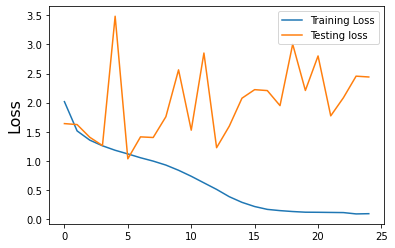

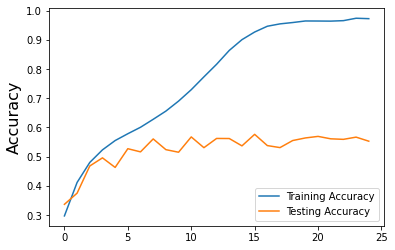

In [28]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(20,20))
# plt.subplot(1,2,1)
# plt.suptitle('Optimizer: Adam',fontsize=18)
plt.figure()
plt.ylabel('Loss',fontsize=16)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Testing loss')
plt.legend(loc='upper right')

# plt.subplot(1,2,2)
plt.figure()
plt.ylabel('Accuracy',fontsize=16)
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Testing Accuracy')
plt.legend(loc='lower right')

plt.show()

It is evident the model overfits. This may be a side effect of the class imbalance.

<Figure size 432x288 with 0 Axes>

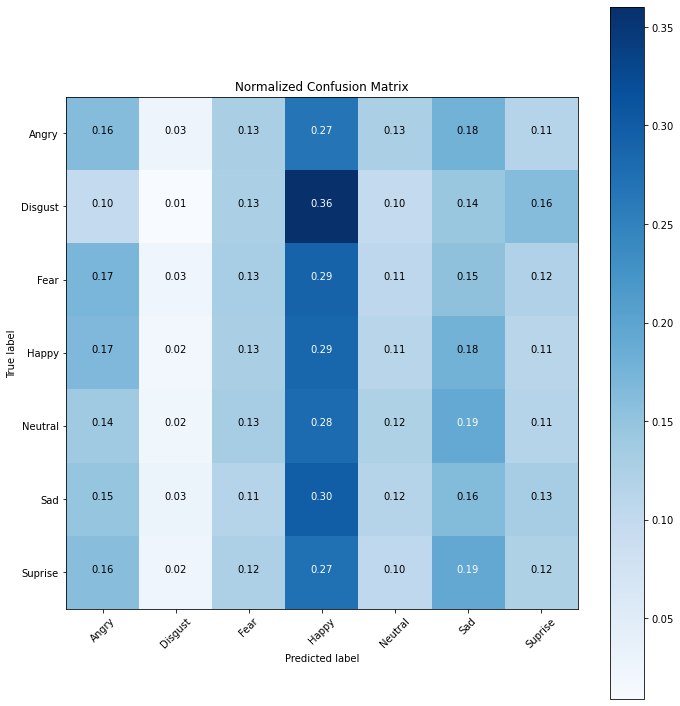

In [29]:
predictions = model.predict_generator(generator=test_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm,classes,title='Confusion matirx',cmap=plt.cm.Blues):
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    pass

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat, classes=class_names, title='Normalized Confusion Matrix')
plt.show()

Due to `Happy` having a high number of images in both the datasets the model is heavily inclinde towards it. This can be mitigated by reducing the number of images of that particular class.

In the next version of the dataset, `Disgust` class is being removed until more images of that particular class can be obtained.

In [30]:
test_acc = model.evaluate_generator(test_generator)
print("Test accuracy: ",test_acc[1])

Test accuracy:  0.5516856908798218


This slightly better than pure random chance. *Not a good dataset.*

In [31]:
pred_generator = datagen_test.flow_from_directory(base_path + "Testing/Testing",
                                                 target_size = (pic_size,pic_size),
                                                 color_mode = "grayscale",
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 shuffle=False)

Found 7178 images belonging to 7 classes.


In [32]:
pred_generator.reset()
pred_class = model.predict_generator(pred_generator,verbose=1,steps=len(pred_generator))

113/113 [==============================] - 5s 42ms/step


In [34]:
labels = pred_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Neutral',
 5: 'Sad',
 6: 'Suprise'}

In [35]:
pred_class = np.argmax(pred_class,axis=1)

pred_class = [labels[k] for k in pred_class]

filenames = pred_generator.filenames
actual_class = [labels[h] for h in pred_generator.classes]

pred_result = pd.DataFrame({"Filename":filenames,
                           "Predictions":pred_class,
                           "Actual Values":actual_class})

pred_result.head()

,Filename,Predictions,Actual Values
0,Angry/Angry-1.jpg,Fear,Angry
1,Angry/Angry-10.jpg,Angry,Angry
2,Angry/Angry-100.jpg,Sad,Angry
3,Angry/Angry-101.jpg,Angry,Angry
4,Angry/Angry-102.jpg,Angry,Angry


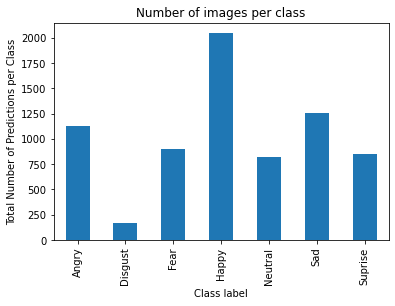

In [37]:
pred_class_result = pred_result["Filename"].groupby(pred_result["Predictions"]).count()

plt.figure()
pred_results_visualisations = pred_class_result.plot(kind='bar')

plt.title("Number of images per class")
plt.xlabel("Class label")
plt.ylabel("Total Number of Predictions per Class")

plt.show()

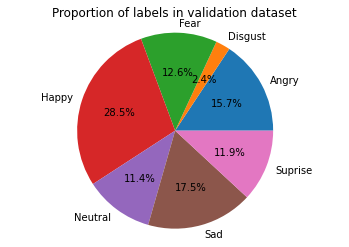

In [38]:
_,result_count = np.unique(pred_class,return_counts=True)

plt.pie(result_count,
       explode=(0,0,0,0,0,0,0),
       labels = class_names,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title('Proportion of labels in validation dataset')
plt.show()

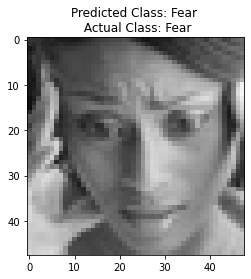

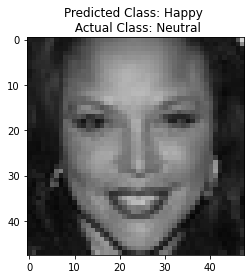

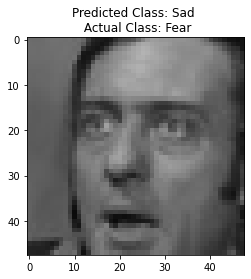

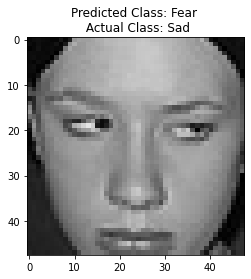

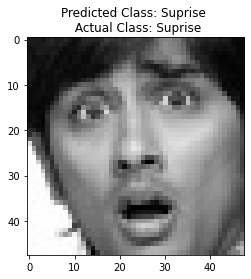

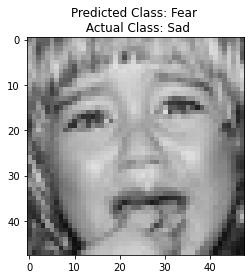

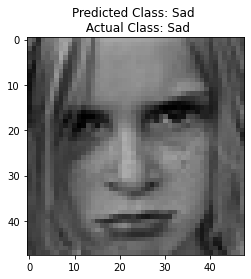

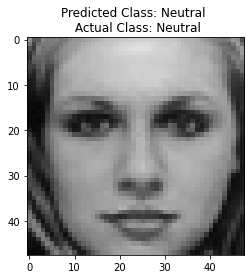

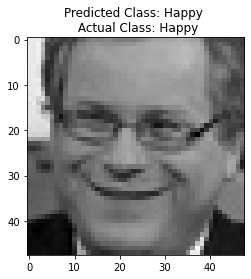

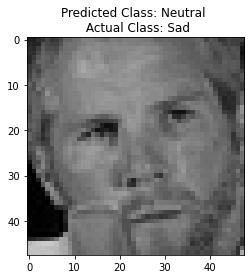

In [44]:
from random import randint

l = len(filenames)
base_path = "/kaggle/input/facial-recognition-dataset/Testing/Testing/"
for i in range(10):
    
    rnd_number = randint(0,l-1)
    filename,pred_class,actual_class = pred_result.loc[rnd_number]
    
    img_path = os.path.join(base_path,filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Predicted Class: {} {} Actual Class: {}".format(pred_class,'\n',actual_class))
    plt.show()
    pass